# Aligning two images

In the previous chapter we developed an algorithm for computing the distance between colors, and used this to apply a threshold to our image, thereby developing a "mask" of water on the surface of the earth.  But what if we wanted to compare our mask to another image, for example, to a mask someone else developed?  In such a case we would need to ensure that our two images overlapped appropriately.  Lets try and accomplish that in this lesson.

We'll begin by replicating the mask you made in the previous lesson.  Either try and recall the value you used previously, or interact with the image in order to develop a new one.

**NOTE: the mask you make here (using the specified threshold) will be used in subsequent sections. If the mask is not set well here, you won't get good results later.**

**ALSO IMPORTANT: once the mask is to your liking DO NOT run the cell again (as this will reset the threshold to 0)**

In [5]:
#lets begin by setting up paths and files

#this code ensures that we can navigate the WiMSE repo across multiple systems
import subprocess
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#move to the top of the directory
os.chdir(gitRepoPath)

#file name of standard map of the world
firstMapName='Earthmap1000x500.jpg'

#file name of grayscale map of the world
grayscaleMapName='World_map_blank_without_borders.svg.png'

#import PIL package
import PIL
from PIL import Image

#establish paths to first image
firstMapPath=os.path.join(gitRepoPath,'images',firstMapName) 
firstMap= Image.open(firstMapPath)
#set first image data as array
firstMapArray=np.asarray(firstMap)
#get the shape
firstMapShape=firstMapArray.shape

#NOW EXTRACT PARTICULAR COLOR INFORMATION

#get the atlanticPixel color
atlanticColor=firstMapArray[450,400]

#make the initial difference computation
zeroBlueMask=np.subtract(firstMapArray,atlanticColor)

#COMPUTE THE COLOR DISTANCE

import matplotlib.pyplot as plt

#quick and dirty general use hypoteuse algorithm, can be used for 2d or 3D
def multiDHypot(coords1,coords2):
    dimDisplace=np.subtract(coords1,coords2)
    elementNum=dimDisplace.size
    elementSquare=np.square(dimDisplace)
    elementSquareSum=np.sum(elementSquare)
    if elementNum==1:
        hypotLeng=dimDisplace
    elif elementNum==2:
        hypotLeng=np.sqrt(elementSquareSum)
    elif elementNum==3:
        hypotLeng=np.sqrt(elementSquareSum)
    return hypotLeng

#initalize distance storage structure
colorDistMeasures=np.zeros(([firstMapShape[0],firstMapShape[1]]))

#iteratively apply the distance computation
for iRows in range(firstMapShape[0]):
    for iColumns in range(firstMapShape[1]):
        #extract the current pixel
        curPixelVal=zeroBlueMask[iRows,iColumns]
        
        #compute the color distance for this pixel, and store it in the corresponding stpot
        #in colorDistMeasures, use this if your input above was firstMapArray
        #Sidenote:  This may require additional code modifications
        #colorDistMeasures[iRows,iColumns]=multiDHypot(curPixelVal,atlanticColor)
    
        #compute the color distance for this pixel, and store it in the corresponding stpot
        #in colorDistMeasures, use this if your input above was zeroBlueMask
        #we use [0 0 0 ] as our input because zeroBlueMask has already had the atlantic blue
        #subtracted from it
        colorDistMeasures[iRows,iColumns]=multiDHypot(curPixelVal,[0, 0, 0])

#data structure formatting for plotting
flattenedDistances=np.ndarray.flatten(colorDistMeasures)

#CREATE THE MASK
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider
from ipywidgets import FloatSlider

#function for modifying the plot via the input cutVal
def updatePlots(DistanceArray,cutVal):

    #modify input data structure
    flattenedDistances=np.ndarray.flatten(DistanceArray)
    
    #set plot features for histogram with cutVal line
    plt.subplot(3, 1, 1)
    plt.hist(flattenedDistances, bins=100)
    plt.xlabel('Distance from ocean color')
    plt.ylabel('Number of pixels')
    plt.title('Distributon of RGB color distance from Atlantic pixel color')
    xposition = [cutVal]
    for xc in xposition:
        plt.axvline(x=xc, color='r', linestyle='--', linewidth=3)
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
     
    #compute binarized mask for values below cutVal
    naieveOceanMask=DistanceArray<cutVal
    
    #plot the image that results
    plt.subplot(3, 1, 2)
    imshow(naieveOceanMask)
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    maskLabels = 'Presumed water', 'Presumed land'
    maskSizes = [np.sum(naieveOceanMask==1),np.sum(naieveOceanMask==0)]
    #implement pie chart plot here

#create the function to manipulate
def updateCut(cutVal):
    updatePlots(colorDistMeasures,cutVal)

#establish the cutVal variable
cutVal=FloatSlider(min=np.min(flattenedDistances), max=np.max(flattenedDistances), step=1,continuous_update=False)

#establish interactivity
interact(updateCut, cutVal=cutVal) 

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='cutVal', max=441.6729559300…

<function __main__.updateCut(cutVal)>

Now, lets take a look at [a map that was generated *specifically* for the purpose of demarcating land and water](https://commons.wikimedia.org/wiki/File:World_map_blank_without_borders.svg).  We'll also print out some information about the image, like its dimensions and color properties.

PNG (4378, 2435) RGBA

Ratio of width to height
1.797946611909651



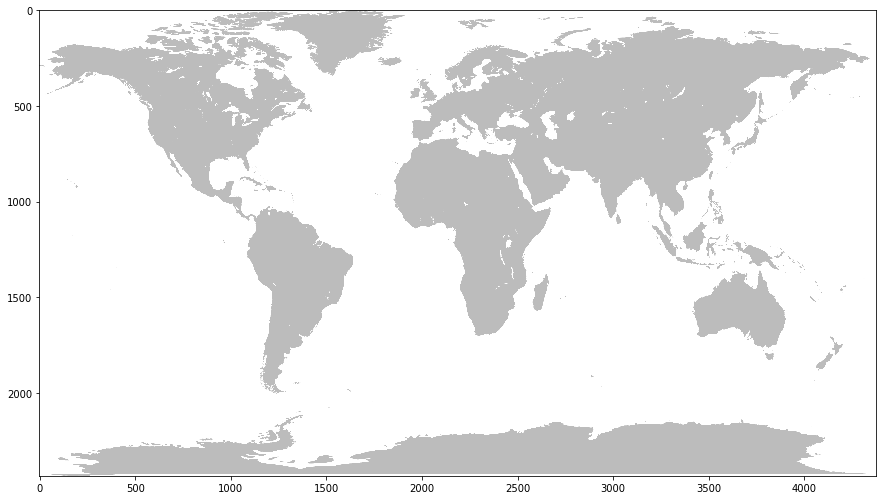

In [10]:
grayscaleMapPath=os.path.join(gitRepoPath,'images',grayscaleMapName) 
grayscaleMap= Image.open(grayscaleMapPath)
print(grayscaleMap.format,grayscaleMap.size , grayscaleMap.mode)
print('')

grayscaleMapDim=grayscaleMap.size

#quick computation to obtain native aspect ratio approximation relative to preeceding image's 2:1
grayscaleMapApsectRatio=grayscaleMapDim[0]/grayscaleMapDim[1]
print('Ratio of width to height')
print(grayscaleMapApsectRatio)
print('')

#in order to display in jupyter, some trickery is necessary
%matplotlib inline
imshow(np.asarray(grayscaleMap))
fig = plt.gcf()
fig.set_size_inches(15, grayscaleMapApsectRatio*15)

From the above output plot we can note that its simply a binary grayscale output, with white indicating water and grey indicating land.  Although the data is stored in a RGBA format (and thus leverages data across **4** different color channels) really, this same output could be accomplished using a single, 2d array as there are only two different colors being displayed.  In fact, in order to compare this to the result we generated, we'll have to convert it into a binary mask (a data array that contains only 1s and 0s, indicating true and false values respectively).  As such the 4 channels ultimately don't matter that much in this image.

However, it also seems that the dimensions and aspect ratio of this image are different than the first image.  Although this is still a map depicting the world, we can now notice that are axes are about 4 times larger than the previous image.  This means that each pixel of this map is representing about 1/16th as much  surface area as the previous image.  Even if we were to simply shrink the image, we would still have a problem overlaying it with the first image due to the discrepancy in aspect ratio. As such,if are to successfully overlay the images on to one another in order to compare them, we will have to resize the figure so that it is of the same dimensions and aspect ratio as our generated mask.

Lets do that now.

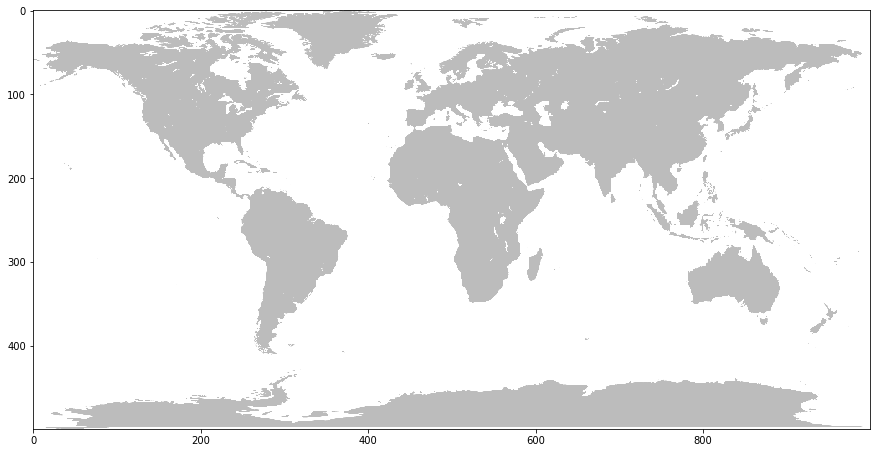

In [11]:
#resize the image
grayscaleResized=grayscaleMap.resize([firstMapShape[1],firstMapShape[0]], resample=0)

#do the plotting
%matplotlib inline
grayscaleResizedData=np.asarray(grayscaleResized)
imshow(np.asarray(grayscaleResizedData))
fig = plt.gcf()
fig.set_size_inches(15, 30)

Note that the axes are now the same as the previous satellite image. Now that we have it resized, lets convert it to a 2D mask like we did previously.  This time though, we don't need to apply a specific threshold because there are only really two values in the image: gray and white. 

Lets plot this output in the same fashion we did the mask we obatined from the satellite.

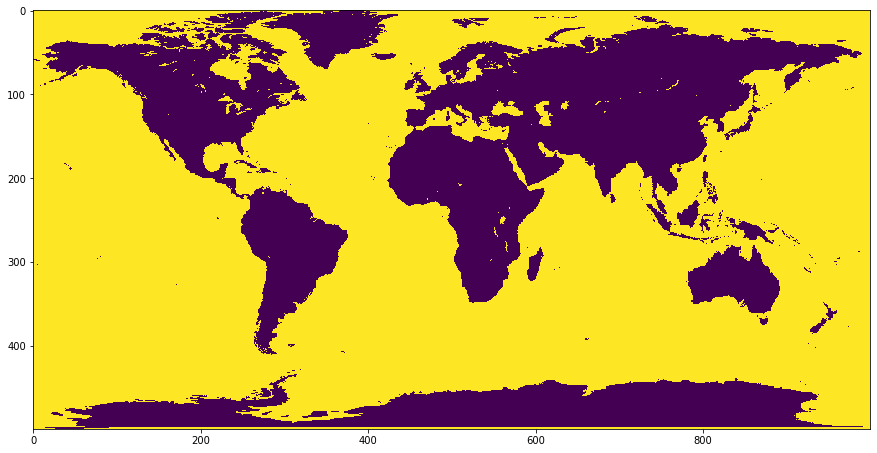

In [12]:
#create binarized, a simple sum will give us the output we seek,
# as there are only two distinct color values in the plot
flatBinarized=np.sum(np.asarray(grayscaleResizedData),axis=2)

imshow(np.logical_not(flatBinarized))
fig = plt.gcf()
fig.set_size_inches(15, 30)

### Plotting the masks overlain

Now lets plot our two masks (user generated version and provided version) together in the plot.  Here we'll change the colors that we are using.  Red (i.e. "problem") pixels will indicate that there is a disagreement between the two masks.  This will occur when one says that the pixel is water while the other says that it is land.  Yellow pixels (i.e. "OK") will indicate pixels in which the two masks agree with one another, in that they both either indicate "land" or "water" 

Lets take a look at that now

#### What sorts of trends or regularities do you notice in the disagreement between the two maps?

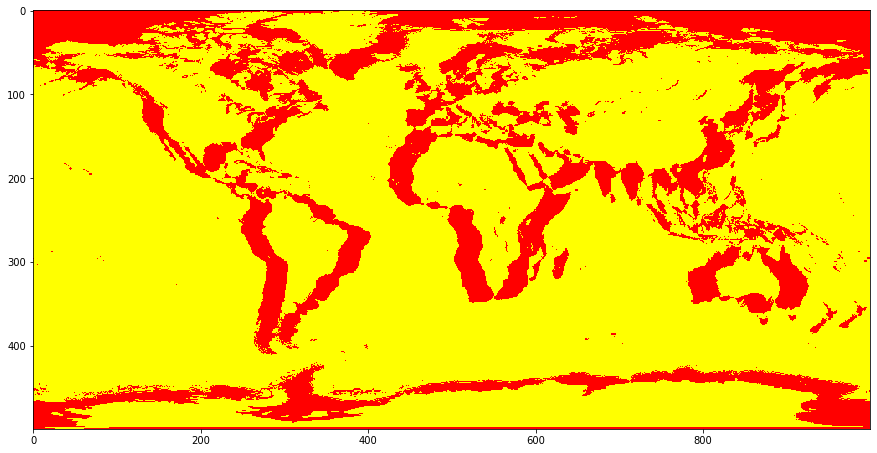

In [13]:
#apply the mask
naieveOceanMask=colorDistMeasures>cutVal.value
#create binary mask for new file
obtainedOceanMask=flatBinarized==0
#find the differences between the two 
discrepancyMapping=(np.logical_xor(obtainedOceanMask,naieveOceanMask))

#do the plotting
imshow(discrepancyMapping, cmap='autumn')
fig = plt.gcf()
fig.set_size_inches(15, 30)

#### What's with this pattern we are observing above?  How would you explain this apparent "shadowing" issue?

It appears that the two images are not aligned properly.  Although their resolutions are the same (500 x 1000), this does not appear to be sufficeint to guarentee that they are showing the same exact areas in the same exact pixels.  Given that this is a sphere we could imagine that this is because the "unfolded" map is roated to the left or right a bit, or maybe shifted up or down.  One way to think about this is that the 0,0 point of the two maps, corresponding to the intersection of the equator and the prime maridian, are not aligned.  Lets move these maps around and see if we can adjust them into alignment by moving one of the two images. 

Your goal in the next interactive section will be to maximize the amount of yellow (agreement) being shown in the image below.  You should attempt to maximize the amount of the pie chart indicating agree, and minimize the amount of the pie chart indicating disagree.

#### What are the x and y shifts necessary to acheive alignment?

The xOffset slider will move the the mask that you generated earlier left or right (on top of the land mask that was provided), the yOffset will move your mask up or down. 

Remember:  There are multiple ways to manipulate the slider.  You can use your mouse directly, you can use the arrow keys of your keyboard, or you can enter a number directtly

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider

#make the plot
def plot_mapDiscrepancy(map1,map2): 
    discrepancyMapping=np.logical_xor(map1,map2)
    %matplotlib inline
    imshow(discrepancyMapping,cmap='autumn')
    fig = plt.gcf()
    fig.set_size_inches(15, 30)
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'Agree', 'Disagree'
    sizes = [np.sum(discrepancyMapping==1),np.sum(discrepancyMapping==0)]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes,  labels=labels, autopct='%1.3f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    
#update the plot via input values     
def update(xOffset, yOffset):
    naieveOceanMaskMoved = np.roll(naieveOceanMask,yOffset,0)
    naieveOceanMaskMoved = np.roll(naieveOceanMaskMoved,xOffset,1)
    plot_mapDiscrepancy(obtainedOceanMask,naieveOceanMaskMoved)

#establish interactivity
interact(update, xOffset=IntSlider(min=-30, max=30, step=1,continuous_update=False),  yOffset=IntSlider(min=-30, max=30, step=1,continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='xOffset', max=30, min=-30), Int…

<function __main__.update(xOffset, yOffset)>

It seems that the lowest mismatch percentage you can get is around 17%, which occurs at -28 x offset and -9 y offset.  What accounts for the remaining mismatch?  Part of it likely has to do with how our mask was made (and the threshold value we chose), and that it likely wasnn't entirely perfect.

One major source of discrepancy is the fact that sea ice is not the color of water, but is not included in the purpose-made land mask we obtained either.  Hence our algorithm considers it "land" (because it is not the color of water), even though the gray colored mask (the provided mask) is specific to land (which ice does not count as).

Finally, one final source is likely that the two maps, even if they were to have their equator and prime maridian lined up, may not be warped (reshaped from a surface that covers a sphere) in exactly the same way.  Theoretically we could attempt to apply a **nonlinear warp** (we'll come back to this concept in later lessons) to try and align the two images, but this would be beyond the scope of this introduction to digital image representations and masks.

#### How this relates to neuroimaging


In the next lesson we will see a more complex version of a mask, one which is not binary, but instead features multiple different categories.  That is, instead of just trying to label one thing (i.e. "water") we will try and use the same general approach to label multiple things.  This capability is something that is used in neuroimaging quite frequently.  For example, we often wish to label particular parts of a neuroimaging scan as being some specific part of the brain (e.g. "frontal lobe", "angular gyrus", or "thalamus" etc.).  We'll explore this possibility in 2D with another map in the next lesson.  In later lessons we'll explicitly look at these "multi category masks" (i.e. **parcellations**) in brains.